In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import matplotlib.pyplot as plt
import time
import numpy as np
import video_tools as vt
import cv2  # Internal operations one in BGR
import os
import csv

# Sanity check
print("[video_tools]", vt.__file__)
ROOT = '/home/alex/Desktop/Helico/0_Database/RPi_import/'
TS = '190622_201853'
DATA = '_NN_crops/'
PATH_VIDEO = ROOT+TS+'/'
PATH_POSITIVE = PATH_VIDEO+TS+DATA+'nnSizeCrops/'
images = sorted([img for img in glob.glob(PATH_POSITIVE+'*')])  # Glob glob is not deterministic

PATH_NEGATIVE = PATH_VIDEO+TS+DATA+'Negatives/'
negative_images = sorted([img for img in glob.glob(PATH_NEGATIVE+'*')])

PATH_EXTRACTED = PATH_VIDEO+TS+DATA+'Extracted_helicopters/'
PATH_AUGMENTED = PATH_VIDEO+TS+DATA+'Augmented_data/'

EXT = '.png'  # Image saving format


BLUR = 1
CANNY_THRESH_1 = 10
CANNY_THRESH_2 = 200
MASK_DILATE_ITER = 4
MASK_ERODE_ITER = 4
MASK_COLOR = (0.0,0.0,1.0) # In BGR format
list_max_area = []
MAX_AREA = 60*10

Y_labels = []

info = {}
with open(PATH_VIDEO+'Info.txt') as f:
    data = csv.reader(f, delimiter=':')
    for line in data:
        info[line[0]] = line[1]
print(info)

extractor = vt.extract.extractor(max_area=MAX_AREA)

[video_tools] /home/alex/Desktop/Helico/video_tools/__init__.py
{'Timestamp': '190622_201853', 'Model': 'EC135P2+', 'Registration': 'N139TJ'}


timing = []
for index, img in enumerate(images):
    if index == 10:
        img_array = plt.imread(img)
        t0 = time.perf_counter()
        counter = 0
        for BLUR in range(3, 4, 2):
            for MASK_DILATE_ITER in range(1, 7, 1):
                MASK_ERODE_ITER = MASK_DILATE_ITER
                extractor = extract_ROI.extract(BLUR, CANNY_THRESH_1, CANNY_THRESH_2, MASK_DILATE_ITER, MASK_ERODE_ITER, max_area)
                image_name = str(BLUR) +'_'+ str(MASK_DILATE_ITER) +'_'+ str(MASK_ERODE_ITER)
                list_max_area.append(extractor.extract_helico(img_array, output+image_name))
                counter += 1
        t1 = time.perf_counter()
        timing.append(t1-t0)
        break
    
print("Average time: {:.3f} per image ({:.3f} img/s)".format(np.mean(timing), 1/np.mean(timing)))
print("Max area: {}/{}".format(max(list_max_area), 224*224))

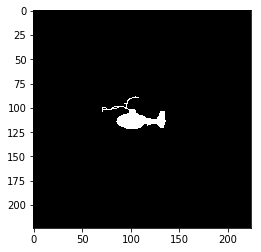

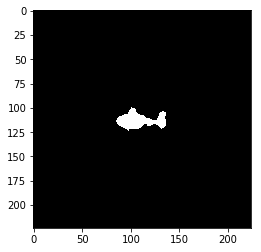

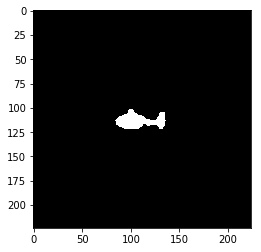

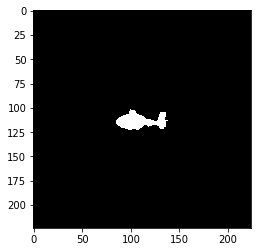

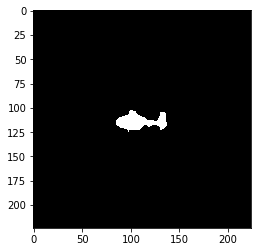

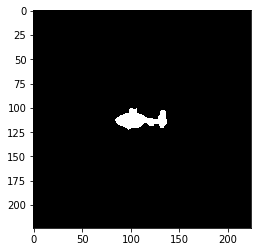

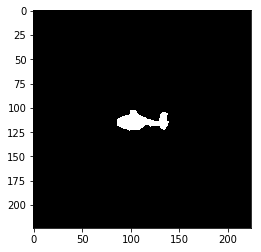

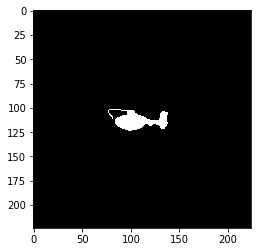

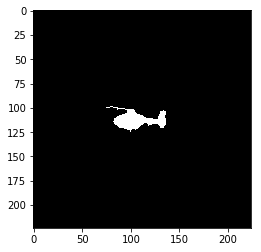

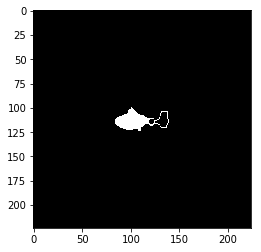

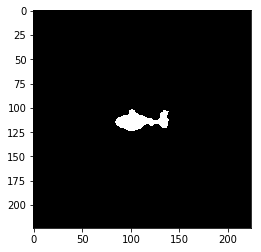

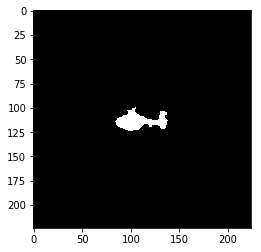

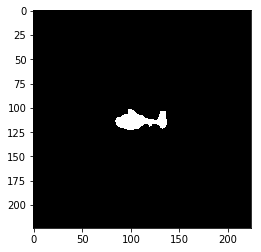

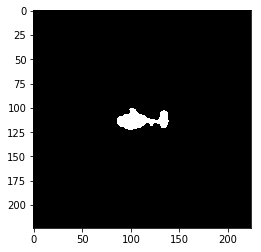

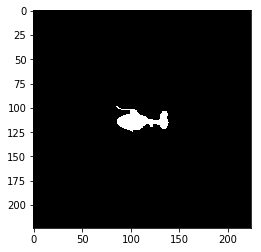

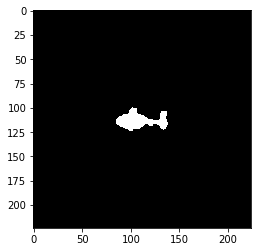

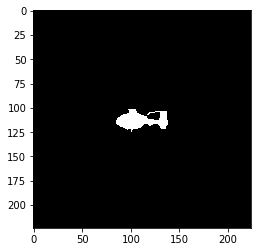

Average time: 0.005 per image (199.534 img/s)


In [3]:
timing = []
for index, img in enumerate(images):
    img_array = cv2.imread(img, cv2.IMREAD_UNCHANGED)
    t0 = time.perf_counter()
    extracted_area, extracted_image = extractor.extract_positive(img_array)
    list_max_area.append(extracted_area)
    if extracted_area:
        #print(np.min(extracted_image), np.max(extracted_image), np.std(extracted_image), extracted_image.shape, extracted_image.dtype)
        #plt.imsave(PATH_EXTRACTED+str(index)+EXT, extracted_image)
        cv2.imwrite(PATH_EXTRACTED+str(index)+EXT, extracted_image)
        #temp = cv2.imread(PATH_EXTRACTED+str(index)+EXT, cv2.IMREAD_UNCHANGED)
        #print(np.min(temp), np.max(temp), np.std(temp), temp.shape, temp.dtype)
        #print()
    t1 = time.perf_counter()
    timing.append(t1-t0)
    
print("Average time: {:.3f} per image ({:.3f} img/s)".format(np.mean(timing), 1/np.mean(timing)))
#print("Max area: {}/{}".format(max(list_max_area), 224*224))

In [4]:
extracted_images = sorted([img for img in glob.glob(PATH_EXTRACTED+'*')])
# Select a random positive image
crop_nb = np.random.randint(len(extracted_images))
img_array = cv2.imread(extracted_images[crop_nb], cv2.IMREAD_UNCHANGED)  # RGB 4 channels
#print("Loaded extracted with range from {} to {}".format(np.min(img_array), np.max(img_array)))
#print(img_array.shape)

Text(0.5, 1.0, 'Helico extracted from crop 68')

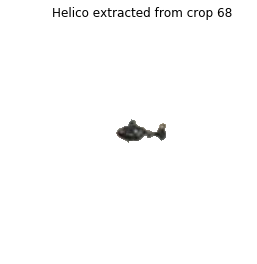

In [5]:
plt.figure()
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGRA2RGBA))
plt.axis('off')
crop_name = os.path.split(extracted_images[crop_nb])[1][:-4]
plt.title("Helico extracted from crop {}".format(crop_name))

In [6]:
# Iterate through all the negative images and blend them with img_array selected above
TOTAL_COUNT = 100  # Number of images to create
HELICO_FREQUENCY = 0.5
# Normal distributions
ROTATIONS = (0, 5)
SCALING = (1, 0.5)  # Truncated to be >= 1

for count in range(TOTAL_COUNT):
    random_neg_index = np.random.randint(len(negative_images))
    neg_img_array = cv2.imread(negative_images[random_neg_index], cv2.IMREAD_UNCHANGED)
    # Select a random positive image to blend with
    random_crop_index = np.random.randint(len(extracted_images))
    img_array = cv2.imread(extracted_images[random_crop_index], cv2.IMREAD_UNCHANGED)  # RGB 4 channels
    """
    plt.figure()
    plt.imshow(cv2.cvtColor(neg_img_array, cv2.COLOR_BGR2RGB))
    plt.show()
    
    plt.figure()
    plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
    plt.show()
    """
    if np.random.rand() <= HELICO_FREQUENCY:
        blended_image = extractor.blend_with_negative(neg_img_array, img_array, rotations=ROTATIONS, scaling=SCALING)
        Y_labels.append(['Helicopter', info['Model']])
    else:
        blended_image = neg_img_array
        Y_labels.append(['Negative', 'None'])
    #blended_image = cv2.cvtColor(blended_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(PATH_AUGMENTED+str(count)+EXT, blended_image)

# Output all the labels to a file
with open(PATH_AUGMENTED+TS+'_labels_aug.txt', 'w') as f:
    out = csv.writer(f)
    for label in Y_labels:
        out.writerow(label)

In [7]:
# Sanity check - read them all and display
Y_read = []
with open(PATH_AUGMENTED+TS+'_labels_aug.txt', 'r') as f:
    data = csv.reader(f)
    for line in data:
        Y_read.append(line)
Y_read

[['Negative', 'None'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Helicopter', 'EC135P2+'],
 ['Helicopter', 'EC135P2+'],
 ['Helicopter', 'EC135P2+'],
 ['Helicopter', 'EC135P2+'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Helicopter', 'EC135P2+'],
 ['Helicopter', 'EC135P2+'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Helicopter', 'EC135P2+'],
 ['Negative', 'None'],
 ['Helicopter', 'EC135P2+'],
 ['Helicopter', 'EC135P2+'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Helicopter', 'EC135P2+'],
 ['Helicopter', 'EC135P2+'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Helicopter', 'EC135P2+'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Helicopter', 'EC135P2+'],
 ['Helicopter', 'EC135P2+'],
 ['Helicopter', 'EC135P2+'],
 ['Negative', 'None'],
 ['Helicopter', 'EC135P2+'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Negative', 'None'],
 ['Nega

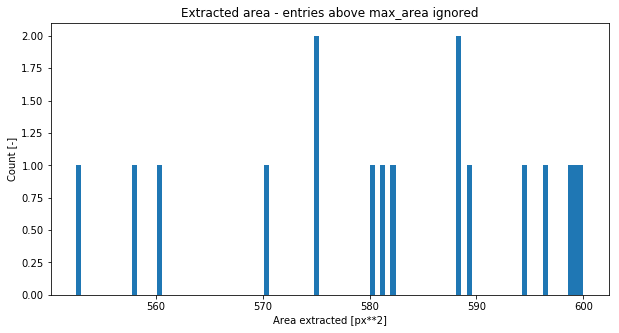

In [8]:
max_bin = 224*224
filtered_list = [v for v in list_max_area if 0 < v <max_bin]
plt.figure(figsize=(10, 5))
plt.hist(filtered_list, bins=100)
plt.title("Extracted area - entries above max_area ignored")
plt.xlabel("Area extracted [px**2]")
plt.ylabel("Count [-]")
plt.show()